In [69]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

In [70]:
from jupyterthemes import jtplot
%matplotlib inline
jtplot.reset()

C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [71]:
nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j',create_using=nx.DiGraph())
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 3622


In [72]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [73]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [in_neighb for (in_neighb,j) in g.in_edges(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum_n = 0
        for n in neighbors:
            sum_n += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum_n)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.738878e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.607654e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,4.422177e+06


In [74]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print('France - Singapore :', g['France']['Singapore'])
print('Singapore - France :', g['Singapore']['France'])

France - Singapore : {'weight': 9515.122402410567}
Singapore - France : {'weight': 12656.470084309465}


In [75]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 52
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

In [76]:
# Creation of new data frames
pop_tot = pd.DataFrame(index = countries.index)
incubating = pd.DataFrame(index = countries.index)
sick = pd.DataFrame(index = countries.index)
infected = pd.DataFrame(index = countries.index)
recovered = pd.DataFrame(index = countries.index)
susceptible = pd.DataFrame(index = countries.index)
deceased = pd.DataFrame(index = countries.index)
ri = pd.DataFrame(index = countries.index)

# # Initialisation for t=0 :
pop_tot['t=0'] = countries['population']
incubating['t=0'] = np.zeros(countries.shape[0])
sick['t=0'] = np.zeros(countries.shape[0])
infected['t=0'] = np.zeros(countries.shape[0])
recovered['t=0'] = np.zeros(countries.shape[0])
susceptible['t=0'] = countries['population']
deceased['t=0'] = np.zeros(countries.shape[0])
ri['t=0'] = np.zeros(countries.shape[0])


# We infect the starting country with a certain number of people
infected.loc[country_start]['t=0'] = nb_infected_start
incubating.loc[country_start]['t=0'] = nb_infected_start
susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

### Computing the reproduction number $R_i$ (average number of people that an incubated person will infect in a week) 
It should :

- Be inversly proportionate to the HDI (with an impact corresponding to beta). We used a linearly decreasing function such that : for a maximal HDI, it should be equal to minus beta time $r_0$, for a minimal HDI, it should be equal to plus beta time $r_0$. Solving these two conditions, we obtain the following affine function's parameters $\large a=-2*\beta*\frac{r_0}{max-min}$ and $\large b=\beta*r_0 - a*min$ where max and min respectively represent the maximum and minimum of the HDI. 
Thus, the HDI's function is $\large f(HDI)=r_0 +a*HDI + b$.

- Decrease with time, since awareness increases, the illness mutates and the immune system adjusts. We used the shape of the sigmoid function to build a function with values between 1 and 0, decreasing slowly at the beginning and at the end, with a higher slope around the middle of the period, here 26 weeks, depending on the alpha parameter. We obtain $\large time(t)=1-\frac{1}{1+e^{(-\alpha * (t-26))}}$. See plot below. 

Finally, we have $R_i(t)=f(HDI)*time(t)$.

In [77]:
print('min HDI: ',countries.hdi.min())
print('max HDI: ',countries.hdi.max())
print('max HDI: ',countries.hdi.median())


min HDI:  0.354
max HDI:  0.946
max HDI:  0.747


In [78]:
# Contamination decreases with time

def time(t):
    # translation to the right
    x=t-30
    # oposite sigmoid + 1
    f=1 -(1/(1+exp(-alpha*x)))
    return f

# Plotting our time function
exp_test=[time(t) for t in range(52)]
plt.title("Time function (sigmoid like)")
plt.xlabel("Time in weeks")
plt.plot(exp_test)

# We calculate the average number infected by an incubated person in a week
# The higher the HDI of a country, the less people will be infected
def reproduction_number_by_country(t):
    minim=countries.hdi.min()
    maxim=countries.hdi.max()
    # Affine function of HDI :
    a=-2*beta*r0/(maxim-minim)
    b=beta*r0-a*minim
    if t==0:
        return (r0 +a*countries['hdi'] + b)
    else:
        # We calculate the percentage of people that can still be infected
        to_be_infected = susceptible.iloc[:,t] / pop_tot.iloc[:,t]
        result = ri.iloc[:,t-1] * to_be_infected
        return result*time(t)

# Let us initialize the ri for t=0
ri['t=0'] = reproduction_number_by_country(0)

print('Country \t HDI \t RI')
print('Afghanistan : \t', countries.loc['Afghanistan']['hdi'], '\t',ri.loc['Afghanistan', 't=0'])
print('France : \t', countries.loc['France']['hdi'], '\t',ri.loc['France', 't=0'])

Country 	 HDI 	 RI
Afghanistan : 	 0.498 	 6.027027027027026
France : 	 0.894 	 3.35135135135135


### Plotting the distibution for the different $R_i$ at $t=0$

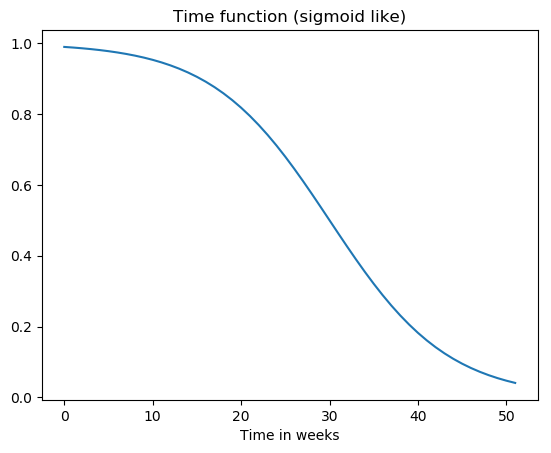

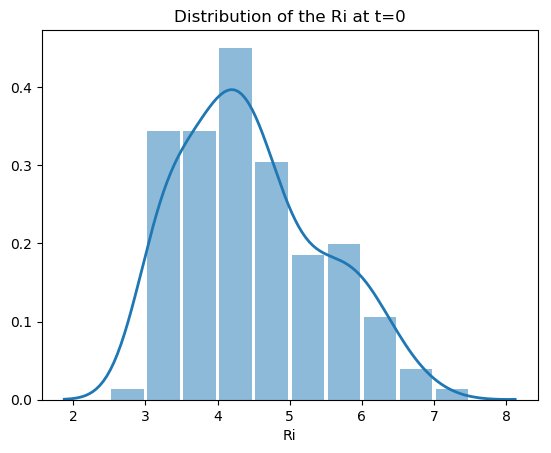

In [79]:
import seaborn as sns

plt.figure()
sns.distplot(ri['t=0'], kde_kws={"lw": 2}, bins = np.arange(2,8,0.5), hist_kws={"linewidth": 3, "rwidth": 0.9, "alpha": 0.5})
plt.title('Distribution of the Ri at t=0')
plt.xlabel('Ri')
plt.show()

In [80]:
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = pd.DataFrame(index = countries.index)
    incubated_coming['nb_coming']=np.zeros(countries.shape[0])
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*incubating.loc[j]['t='+str(t-1)]/(pop_tot.loc[j]['t='+str(t-1)] - sick.loc[j]['t='+str(t-1)])
        incubated_coming.loc[i,'nb_coming'] = round(sum)
        
    return incubated_coming

In [81]:
# Function to actualize (add column corresponding to t) each dataframe t>0 :

def infection_actualization(t, country_start) :
    if t>0 :
        index='t='+str(t)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)

        # actualizing incubating, sick & infected => variables depending on the newly infected people:

        # sick people at time t are the incubated of t-1 who stayed in the country
        sick[index]=incubating.iloc[:,t-1]*(1-(countries.travellers/(pop_tot.iloc[:,t-1]-sick.iloc[:,t-1])))
        
        incubating[index]=sick[index]*ri.iloc[:,t-1]+number_incubated_coming(t).iloc[:,0]*(ri.iloc[:,t-1])

        infected[index]=sick[index]+number_incubated_coming(t).iloc[:,0]+incubating[index]

In [82]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 30
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

In [83]:
# Creation of new data frames
pop_tot = pd.DataFrame(index = countries.index)
incubating = pd.DataFrame(index = countries.index)
sick = pd.DataFrame(index = countries.index)
infected = pd.DataFrame(index = countries.index)
recovered = pd.DataFrame(index = countries.index)
susceptible = pd.DataFrame(index = countries.index)
deceased = pd.DataFrame(index = countries.index)

# # Initialisation for t=0 :
pop_tot['t=0'] = countries['population']
incubating['t=0'] = np.zeros(countries.shape[0])
sick['t=0'] = np.zeros(countries.shape[0])
infected['t=0'] = np.zeros(countries.shape[0])
recovered['t=0'] = np.zeros(countries.shape[0])
susceptible['t=0'] = countries['population']
deceased['t=0'] = np.zeros(countries.shape[0])


# We infect the starting country with a certain number of people
infected.loc[country_start]['t=0'] = nb_infected_start
incubating.loc[country_start]['t=0'] = nb_infected_start
susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

In [84]:
# Create the values for the dataframes, for all periods

def data_creation(period, country_start):
    for i in range(1,period+1):
        infection_actualization(i,country_start = country_start)
        print("Number of periods processed:", i)

In [85]:
data_creation(period, country_start)

Number of periods processed: 1
Number of periods processed: 2
Number of periods processed: 3
Number of periods processed: 4
Number of periods processed: 5
Number of periods processed: 6
Number of periods processed: 7
Number of periods processed: 8
Number of periods processed: 9
Number of periods processed: 10
Number of periods processed: 11
Number of periods processed: 12
Number of periods processed: 13
Number of periods processed: 14
Number of periods processed: 15
Number of periods processed: 16
Number of periods processed: 17
Number of periods processed: 18
Number of periods processed: 19
Number of periods processed: 20
Number of periods processed: 21
Number of periods processed: 22
Number of periods processed: 23
Number of periods processed: 24
Number of periods processed: 25
Number of periods processed: 26
Number of periods processed: 27
Number of periods processed: 28
Number of periods processed: 29
Number of periods processed: 30


## Creation of the DataFrame that will indicate the status of each country, through time
* **Epidemic threshold**: We set it at 200 for 100,000 inhabitants.

The cycle that a country can go trhough is the following:
Susceptible => Exposed => Epidemic => Recovered

* *Susceptible:* all countries start as susceptible.
* *Exposed*: if one person is infected in the country, it is considered exposed.
* *Epidemic:* if the number of infected surpasses the epidemic threshold.
* *Recovered*: if the country was infected, but goes back under the epidemic threshold.

In [86]:
zeros = np.zeros(shape=infected.shape)
country_status=pd.DataFrame(zeros, index = infected.index, columns = infected.columns)
epidemic_threshold=200/100000

# Initialization at t=0, all countries are susceptible except the exposed country
country_status.replace(to_replace= 0, value = 'Susceptible',inplace=True)
country_status.loc[country_start,'t=0']='Exposed'

# Replacing the Epidemic and the Exposed:
for index, row in infected.iterrows():
    for col in infected :
        if infected.loc[index, col] / pop_tot.loc[index, col] > epidemic_threshold:
            country_status.loc[index, col] = 'Epidemic'
        elif infected.loc[index, col] >= 1:
            country_status.loc[index, col] = 'Exposed'

# Replacing the Recovered:
for index, row in country_status.iterrows():
    i=0
    for col in country_status :
        if (country_status.loc[index, col] == 'Exposed' or country_status.loc[index, col] =='Susceptible') and i>0:
            if country_status.loc[index,'t='+str(i-1)] == 'Epidemic' or country_status.loc[index,'t='+str(i-1)] =='Recovered' :
                country_status.loc[index, col]='Recovered'
        i+=1

In [87]:
# Pandemic status : 

pandemic_status=pd.DataFrame(index=country_status.columns)
pandemic_status['status']=False
for t in pandemic_status.index : 
    if ('Epidemic' in country_status.loc[:,t].values) and (country_status.loc[:,t].value_counts()['Epidemic']>=10) :
        pandemic_status.loc[t,'status']=True
        
print('Pandemic starts at: ', pandemic_status.status[pandemic_status.status==True].index[0])
print('Pandemic ends at: ', pandemic_status.status[pandemic_status.status==True].index[-1])

Pandemic starts at:  t=16
Pandemic ends at:  t=25


In [88]:
country_status.sample(n=5)

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,...,t=21,t=22,t=23,t=24,t=25,t=26,t=27,t=28,t=29,t=30
country,,,,,,,,,,,,,,,,,,,,,
Madagascar,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Epidemic,Epidemic,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered
Portugal,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Susceptible,Susceptible
Bulgaria,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,...,Epidemic,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
New Zealand,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Exposed,Susceptible,Susceptible,Susceptible
Togo,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,...,Epidemic,Epidemic,Epidemic,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered


In [89]:
# Saving our results

pop_tot_model = pop_tot.copy()
incubating_model = incubating.copy()
sick_model = sick.copy()
infected_model = infected.copy()
recovered_model = recovered.copy()
susceptible_model = susceptible.copy()
deceased_model = deceased.copy()
ri_model = ri.copy()

# Building the Graph

## Degree analysis: IN and OUT degrees together

In [90]:
# Degree (IN+OUT degrees) per country
in_out_degree = nx.degree(g)
list_in_out_degree = [country for country in in_out_degree]
list_country_name = [degree[0] for degree in list_in_out_degree]
list_degree = [degree[1] for degree in list_in_out_degree]

In [91]:
# Average, min and max (IN+OUT degrees)
degree_min = min(list_in_out_degree, key = lambda t: t[1])
print('Minimum degree is '+ str(degree_min[1]) + ' for '+str(degree_min[0]))
degree_max = max(list_in_out_degree, key = lambda t: t[1])
print('Maximum degree is '+ str(degree_max[1])+' for '+str(degree_max[0]))
degree_mean = np.mean(list_degree)
print('Mean degree is '+ str(degree_mean))
degree_median = np.median(list_degree)
print('Median degree is '+ str(degree_median))

Minimum degree is 2 for Marshall Islands
Maximum degree is 190 for France
Mean degree is 47.973509933774835
Median degree is 38.0


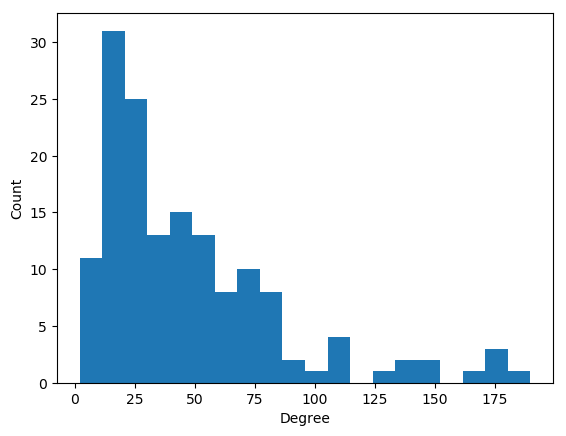

In [92]:
# Degree distribution (IN+OUT degrees)
plt.hist(list_degree,bins = 20)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

## Degree Analysis: IN degrees

In [93]:
# In degree per country
in_degree = g.in_degree()
list_country_in_degree = [country for country in in_degree]
list_in_degree = [degree[1] for degree in list_country_in_degree]

In [94]:
# Average, min and max IN degrees
in_degree_min = min(list_country_in_degree, key = lambda t: t[1])
print('Minimum IN degree is '+ str(in_degree_min[1]) + ' for '+str(in_degree_min[0]))
in_degree_max = max(list_country_in_degree, key = lambda t: t[1])
print('Maximum IN degree is '+ str(in_degree_max[1])+' for '+str(in_degree_max[0]))
in_degree_mean = np.mean(list_in_degree)
print('Mean IN degree is '+ str(in_degree_mean))
in_degree_median = np.median(list_in_degree)
print('Median IN degree is '+ str(in_degree_median))

Minimum IN degree is 1 for Marshall Islands
Maximum IN degree is 95 for France
Mean IN degree is 23.986754966887418
Median IN degree is 19.0


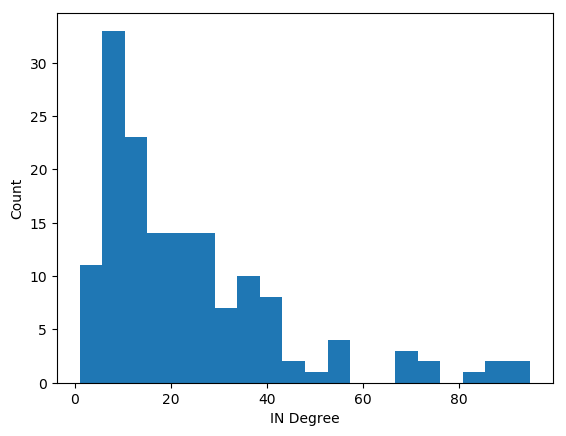

In [95]:
# IN Degree distribution
plt.hist(list_in_degree,bins = 20)
plt.xlabel('IN Degree')
plt.ylabel('Count')
plt.show()

In [96]:
# in_degree centrality 
in_degree_centrality = nx.in_degree_centrality(g)

## Degree Analysis: OUT degrees

In [97]:
# OUT degree per country
out_degree = g.out_degree()
list_country_out_degree = [country for country in out_degree]
list_out_degree = [degree[1] for degree in list_country_out_degree]

In [98]:
# Average, min and max out degrees
out_degree_min = min(list_country_out_degree, key = lambda t: t[1])
print('Minimum out degree is '+ str(out_degree_min[1]) + ' for '+str(out_degree_min[0]))
out_degree_max = max(list_country_out_degree, key = lambda t: t[1])
print('Maximum out degree is '+ str(out_degree_max[1])+' for '+str(out_degree_max[0]))
out_degree_mean = np.mean(list_out_degree)
print('Mean out degree is '+ str(out_degree_mean))
out_degree_median = np.median(list_out_degree)
print('Median out degree is '+ str(out_degree_median))

Minimum out degree is 1 for Marshall Islands
Maximum out degree is 95 for France
Mean out degree is 23.986754966887418
Median out degree is 19.0


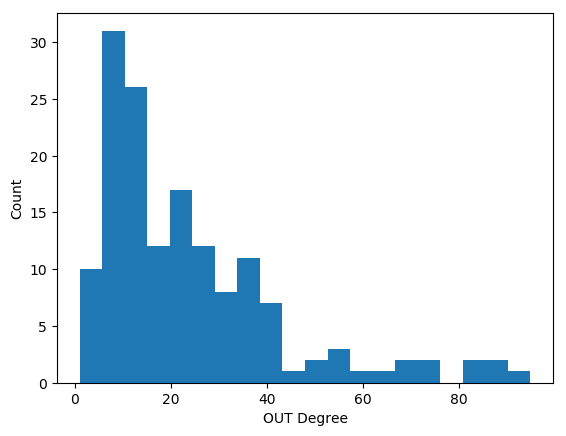

In [99]:
# OUT Degree distribution
plt.hist(list_out_degree,bins = 20)
plt.xlabel('OUT Degree')
plt.ylabel('Count')
plt.show()

In [100]:
# out_degree centrality 
out_degree_centrality = nx.out_degree_centrality(g)

## Shortest path to disease starting node/country

In [101]:
# compute the shortest path to the starting point of the disease
# All countries can be reached in less than 4 steps starting from France
starting_country = 'France'
shortest_path_starting_node = [len(nx.shortest_path(g, source=starting_country, target=target, weight=None)) for target in list_country_name ]
shortest_path_starting_node = pd.DataFrame(shortest_path_starting_node,index=countries.index,columns=['shortest_path'])
shortest_path_starting_node

,shortest_path
country,
Afghanistan,3
Albania,2
Algeria,2
Angola,2
Antigua and Barbuda,3
Argentina,3
Armenia,2
Australia,2
Austria,3


## Betweeness centrality 

In [102]:
# Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v
betweeness_centrality = nx.betweenness_centrality(g)
betweeness_centrality = [betweeness_centrality[centrality] for centrality in betweeness_centrality]
betweeness_centrality = pd.DataFrame(betweeness_centrality,index=countries.index,columns=['betweeness_centrality'])
betweeness_centrality

,betweeness_centrality
country,
Afghanistan,0.000050
Albania,0.000902
Algeria,0.019344
Angola,0.002298
Antigua and Barbuda,0.002334
Argentina,0.000148
Armenia,0.065463
Australia,0.069665
Austria,0.000011


# Node Deletion: modeling the international community's reaction to the pandemy

Random node deletion: We delete a random number of nodes -between 0% and 25%- at time t=i, the first period for which the pandemic is declared.

As this criterion is not precisely set and varies depending on the illness, we have decided to set the pandemic threshold at **10 countries**.

We aim at erasing all the edges of the list of the selected nodes at time t=i, by setting its out weights to 0.  
To do so, we have to modify our previous fomulas.

In [103]:
# Modifying the incubated people coming to the country at time t
def number_incubated_coming_deletion(t,countries_to_delete):
    incubated_coming = pd.DataFrame(index = countries.index)
    incubated_coming['nb_coming']=np.zeros(countries.shape[0])
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            # Modifying the formula so that the erased edges are not counted
            if j not in countries_to_delete:
                sum += g[j][i]['weight']*incubating.loc[j]['t='+str(t-1)]/(pop_tot.loc[j]['t='+str(t-1)] - sick.loc[j]['t='+str(t-1)])
        incubated_coming.loc[i,'nb_coming'] = round(sum)
        
    return incubated_coming

In [104]:
# Modifying the function that creates the DataFrames at time t

def infection_actualization_deletion(t, country_start, pandemic_start, countries_to_delete) :
    if t==0:
        print("Error: t must be strictly greater than zero ! --' ")
    elif t< pandemic_start:
        index='t='+str(t)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)

        # actualizing incubating, sick & infected => variables depending on the newly infected people:
        # sick people at time t are the incubated of t-1 who stayed in the country
        sick[index]=incubating.iloc[:,t-1]*(1-(countries.travellers/(pop_tot.iloc[:,t-1]-sick.iloc[:,t-1])))
        incubating[index]=sick[index]*ri.iloc[:,t-1]+number_incubated_coming(t).iloc[:,0]*(ri.iloc[:,t-1])
        infected[index]=sick[index]+number_incubated_coming(t).iloc[:,0]+incubating[index]
        
    else:
        index='t='+str(t)
        index_prev = 't='+str(t-1)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)

        # actualizing incubating, sick & infected => variables depending on the newly infected people:
        # sick people at time t are the incubated of t-1 who stayed in the country
        
        nb=number_incubated_coming_deletion(t, countries_to_delete)
        
        for i,row in infected.iterrows():
            # sick people are considered not contagious for simplicity
            if i in countries_to_delete :
                sick.loc[i,index]=incubating.loc[i,index_prev]
                incubating.loc[i,index]=sick.loc[i,index]*ri.loc[i,index_prev]
                infected.loc[i,index]=sick.loc[i,index]+incubating.loc[i,index]
                
            else :
                sick.loc[i,index]=incubating.loc[i,index_prev]*(1-(countries.travellers[i]/(pop_tot.loc[i,index_prev]-sick.loc[i,index_prev])))
                incubating.loc[i,index]=sick.loc[i,index]*ri.loc[i,index_prev]+ nb.loc[i,'nb_coming']*(ri.loc[i,index_prev])
                infected.loc[i,index]=sick.loc[i,index]+ nb.loc[i,'nb_coming']+incubating.loc[i,index]

In [105]:
# Creating a formula to create all DataFrames

def data_creation_deletion(period, country_start, pandemic_start, countries_to_delete):
    for i in range(1,period+1):
        infection_actualization_deletion(i,country_start = country_start, pandemic_start = pandemic_start, countries_to_delete = countries_to_delete)
    if i == pandemic_start:
        print("\n", "START OF THE PANDEMIC !!!", "\n")
    print("Number of periods processed:", i)


In [106]:
# Defining the countries to delete

# First case : random deletion :
import random 

def countries_to_delete_random(percentage) :
    ListOfNodes = g.nodes()
    NumberofNodes = g.number_of_nodes()
    
    sample = int(NumberofNodes*(percentage/100))
    RandomSample = random.sample(ListOfNodes, sample)
    return RandomSample

# test 
print(countries_to_delete_random(25))

# Second case : Targeted deletion :
def countries_to_delete_targeted(percentage):
    NumberofNodes = g.number_of_nodes()
    sample = int(NumberofNodes*(percentage/100))
    
    # Finding nodes with highest degree
    tuples = sorted([(d,n) for n, d in g.degree()], reverse=True)
    
    nodes_to_delete = []
    for j in range(sample):
        nodes_to_delete.append(tuples[j][1])
    return nodes_to_delete

# test 
print(countries_to_delete_targeted(25))

['Bulgaria', 'Madagascar', 'Bhutan', 'Gabon', 'Russia', 'Cuba', 'Belarus', 'Czech Republic', 'Marshall Islands', 'Guyana', 'Senegal', 'Nicaragua', 'Albania', 'Uzbekistan', 'Bolivia', 'Kuwait', 'Austria', 'Sri Lanka', 'Mexico', 'Panama', 'Canada', 'Antigua and Barbuda', 'Morocco', 'Netherlands', 'Nepal', 'Cape Verde', 'Estonia', 'Brunei', 'Hong Kong', 'Angola', 'Brazil', "Cote d'Ivoire", 'Mauritius', 'China', 'Guatemala', 'Fiji', 'Thailand']
['France', 'Germany', 'United Kingdom', 'Turkey', 'United Arab Emirates', 'Italy', 'Netherlands', 'United States', 'Spain', 'Russia', 'Switzerland', 'China', 'Austria', 'Belgium', 'Thailand', 'Canada', 'India', 'Egypt', 'Denmark', 'Greece', 'Saudi Arabia', 'Sweden', 'Israel', 'Poland', 'Ethiopia', 'Morocco', 'Finland', 'Czech Republic', 'South Africa', 'South Korea', 'Portugal', 'Norway', 'Hong Kong', 'Kenya', 'Ukraine', 'Singapore', 'Jordan']


In [109]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 30
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1
pandemic_start = int((pandemic_status.status[pandemic_status.status==True].index[0])[2:])

#def rnd(type_of_deletion) :
type_of_deletion='random'
nb_infected_random=[]

# Implementation :
for i in range(0, 45, 5) :

    print(i,"% of deleted Nodes")

    #initialization :
    # Creation of new data frames
    pop_tot = pd.DataFrame(index = countries.index)
    incubating = pd.DataFrame(index = countries.index)
    sick = pd.DataFrame(index = countries.index)
    infected = pd.DataFrame(index = countries.index)
    recovered = pd.DataFrame(index = countries.index)
    susceptible = pd.DataFrame(index = countries.index)
    deceased = pd.DataFrame(index = countries.index)

    # # Initialisation for t=0 :
    pop_tot['t=0'] = countries['population']
    incubating['t=0'] = np.zeros(countries.shape[0])
    sick['t=0'] = np.zeros(countries.shape[0])
    infected['t=0'] = np.zeros(countries.shape[0])
    recovered['t=0'] = np.zeros(countries.shape[0])
    susceptible['t=0'] = countries['population']
    deceased['t=0'] = np.zeros(countries.shape[0])


    # We infect the starting country with a certain number of people
    infected.loc[country_start]['t=0'] = nb_infected_start
    incubating.loc[country_start]['t=0'] = nb_infected_start
    susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

    # Running :
    if type_of_deletion == 'random':
        countries_to_delete=countries_to_delete_random(i)
    elif type_of_deletion == 'targeted':
        countries_to_delete=countries_to_delete_targeted(i)
    else:
        print("Type of deletion is either 'random' or 'targeted' ")
    data_creation_deletion(period, country_start, pandemic_start, countries_to_delete)

    # Saving the results :
    print('Total people infected:', incubating.sum().sum(), '\n')
    nb_infected_random.append(incubating.sum().sum())
print(nb_infected_random)

0 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201716468.07469812 

5 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201468473.641925 

10 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195373235.1448749 

15 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201296007.46488017 

20 % of deleted Nodes
Number of periods processed: 30
Total people infected: 200335806.9881361 

25 % of deleted Nodes
Number of periods processed: 30
Total people infected: 197701911.27937457 

30 % of deleted Nodes
Number of periods processed: 30
Total people infected: 198122023.3523531 

35 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194961194.14805925 

40 % of deleted Nodes
Number of periods processed: 30
Total people infected: 197506265.13159066 

[201716468.07469812, 201468473.641925, 195373235.1448749, 201296007.46488017, 200335806.9881361, 197701911.27937457, 19812202

In [110]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 30
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1
pandemic_start = int((pandemic_status.status[pandemic_status.status==True].index[0])[2:])

#def rnd(type_of_deletion) :
type_of_deletion='targeted'
nb_infected_targeted=[]

# Implementation :
for i in range(0, 45, 5) :

    print(i,"% of deleted Nodes")

    #initialization :
    # Creation of new data frames
    pop_tot = pd.DataFrame(index = countries.index)
    incubating = pd.DataFrame(index = countries.index)
    sick = pd.DataFrame(index = countries.index)
    infected = pd.DataFrame(index = countries.index)
    recovered = pd.DataFrame(index = countries.index)
    susceptible = pd.DataFrame(index = countries.index)
    deceased = pd.DataFrame(index = countries.index)

    # # Initialisation for t=0 :
    pop_tot['t=0'] = countries['population']
    incubating['t=0'] = np.zeros(countries.shape[0])
    sick['t=0'] = np.zeros(countries.shape[0])
    infected['t=0'] = np.zeros(countries.shape[0])
    recovered['t=0'] = np.zeros(countries.shape[0])
    susceptible['t=0'] = countries['population']
    deceased['t=0'] = np.zeros(countries.shape[0])


    # We infect the starting country with a certain number of people
    infected.loc[country_start]['t=0'] = nb_infected_start
    incubating.loc[country_start]['t=0'] = nb_infected_start
    susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

    # Running :
    if type_of_deletion == 'random':
        countries_to_delete=countries_to_delete_random(i)
    elif type_of_deletion == 'targeted':
        countries_to_delete=countries_to_delete_targeted(i)
    else:
        print("Type of deletion is either 'random' or 'targeted' ")
    data_creation_deletion(period, country_start, pandemic_start, countries_to_delete)

    # Saving the results :
    print('Total people infected:', incubating.sum().sum(), '\n')
    nb_infected_targeted.append(incubating.sum().sum())
print(nb_infected_targeted)

0 % of deleted Nodes
Number of periods processed: 30
Total people infected: 201716468.07469812 

5 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194700857.96557832 

10 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194432328.09011352 

15 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194376102.3792726 

20 % of deleted Nodes
Number of periods processed: 30
Total people infected: 194829292.60676387 

25 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195019857.45369035 

30 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195289579.65341195 

35 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195362768.4916694 

40 % of deleted Nodes
Number of periods processed: 30
Total people infected: 195408765.20858166 

[201716468.07469812, 194700857.96557832, 194432328.09011352, 194376102.3792726, 194829292.60676387, 195019857.45369035, 19

Conclusions :
=> targeted deletion works better at reducing the number of infected people.
=> but it seems to be limited and does not decrease much. Why?
=> graph is hyperconnected. Even if a high degree node is deleted, there remain enough other connected nodes to transmit the illness.
=> the pandemic state is declared too late. When 10 countries are under epidemy, the virus has already spread to way more.

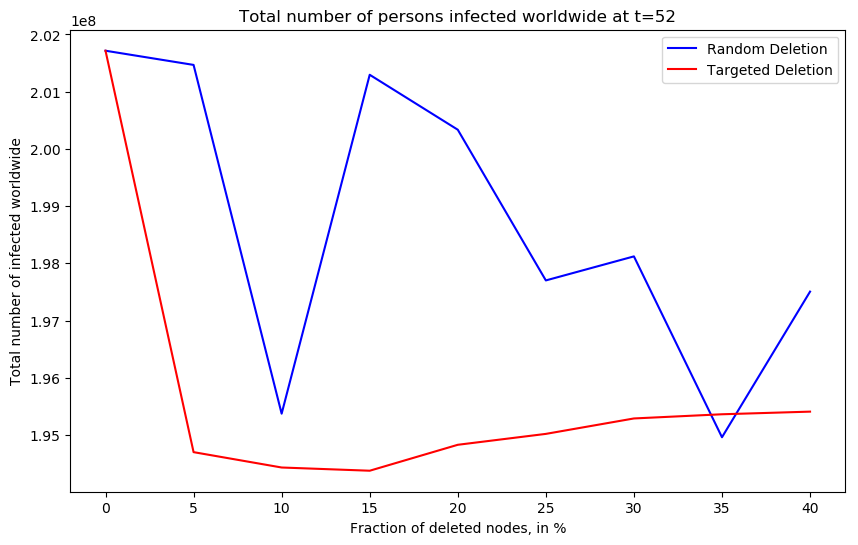

In [112]:
x = list(range(0, 45, 5))

fig, ax = plt.subplots(figsize=(10,6))

plt.plot(x, nb_infected_random, label = 'Random Deletion', color = 'b')
plt.plot(x, nb_infected_targeted, label = 'Targeted Deletion', color = 'r')


plt.title("Total number of persons infected worldwide at t=52")
plt.xlabel("Fraction of deleted nodes, in %")
plt.ylabel("Total number of infected worldwide")
plt.legend()

plt.show()